<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


# Registration of an Image Stack

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/EELS/Analysis_Core_Loss.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/EELS/Analysis_Core_Loss.ipynb)

    
part of Online Course

<font size = "5"> **[Machine Learning in Scanning Electron Microscopy 2023](https://github.com/pycroscopy/pyTEMlib)**</font>

<font size = "3"> **[Notebooks of Lecture 2](https://github.com/pycroscopy)**</font>



Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville



## Prerequesites

### Install pyTEMlib

In Google Colab you have to install first all the necessary additional packages. For a local installation, this has to be run only once.


In [61]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.5.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q
    !{sys.executable} -m pip install simpleitk
    
# ------------------------------
print('done')

done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 

Demon registration requires


In [ ]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../../../pyTEMlib')

In [60]:
%matplotlib ipympl
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive


import pyTEMlib
from pyTEMlib import file_tools     # File input/ output library
from pyTEMlib import image_tools

import pycroscopy
# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2023_5_20'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2023.5.2


## Open File

### Choose Mode of  File Selection

In ``Google Colab``, one cannot open a ''QT'' dialog window and so we will use the ``FileWidget`` class of pyTEMlib to select a file.
This allows to also select the dataset within this file, if such a file contains multiple datasets.

In case of a local installation, a normal file dialog ``FileDialog`` class  is available to select a file.
However, you'll still need to select a dataset if multiple datasets are available. We will use a ''ChooseDatset'' class later for that purpose.

The FileWidget will use display the name of a Nion File like in NionSwift and is often the better way for those files. 

Go to the directory (a mounted google drive would be at drive/Mydrive

In [2]:
### Open file widget
fileWidget = file_tools.FileWidget()

### Load File

If you did not choose the file widget a File Dialog window will open in the next code cell.

Otherewise just select a File in the widget above

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

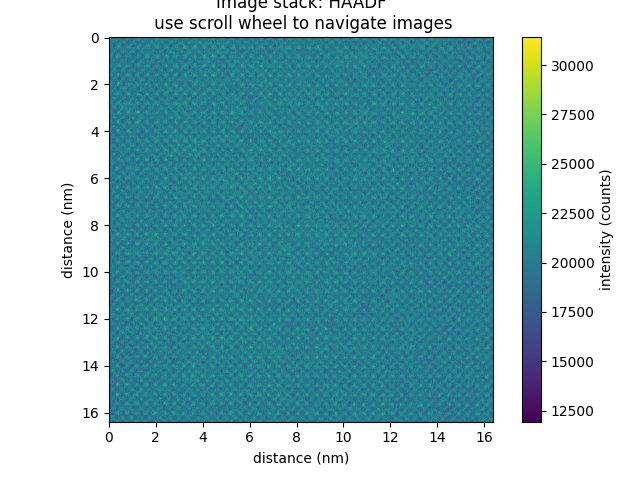

In [5]:
datasets = fileWidget.datasets

dataset = fileWidget.selected_dataset
if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need a stack of images here')
    
view = dataset.plot()

In [6]:
dataset = chooser.dataset

if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need an image here')

view = dataset.plot()

NameError: name 'chooser' is not defined

## First: Rigid Registration

If this is an image stack we need to register and add the images. 

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 

In [7]:
from pyTEMlib import image_tools
rigid_registered = image_tools.rigid_registration(dataset)
v = rigid_registered.plot()

Stack contains  20  images, each with 1024  pixels in x-direction and  1024  pixels in y-direction


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


TypeError: When specifying values over which a parameter is varied, values should not be an empty array

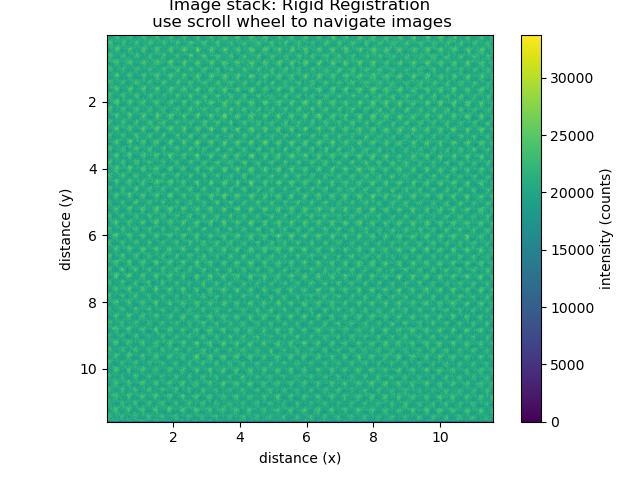

In [6]:
view = rig_reg_dataset.plot()
# rig_reg_dataset

In [8]:
def rig_reg_drift(dset, rel_drift):
    """ Shifting images on top of each other

    Uses relative drift to shift images on top of each other,
    with center image as reference.
    Shifting is done with shift routine of ndimage from scipy.
    This function is used by rigid_registration routine

    Parameters
    ----------
    dset: sidpy.Dataset
        dataset with image_stack
    rel_drift:
        relative_drift from image to image as list of [shiftx, shifty]

    Returns
    -------
    stack: numpy array
    drift: list of drift in pixel
    """

    frame_dim = []
    spatial_dim = []
    selection = []

    for i, axis in dset._axes.items():
        if axis.dimension_type.name == 'SPATIAL':
            spatial_dim.append(i)
            selection.append(slice(None))
        else:
            frame_dim.append(i)
            selection.append(slice(0, 1))

    if len(spatial_dim) != 2:
        print('need two spatial dimensions')
    if len(frame_dim) != 1:
        print('need one frame dimensions')

    rig_reg = np.zeros([dset.shape[frame_dim[0]], dset.shape[spatial_dim[0]], dset.shape[spatial_dim[1]]])

    # absolute drift
    drift = np.array(rel_drift).copy()

    drift[0] = [0, 0]
    for i in range(drift.shape[0]):
        drift[i] = drift[i - 1] + rel_drift[i]
    center_drift = drift[int(drift.shape[0] / 2)]
    drift = drift - center_drift
    # Shift images
    for i in range(rig_reg.shape[0]):
        selection[frame_dim[0]] = slice(i, i+1)
        # Now we shift
        rig_reg[i, :, :] = ndimage.shift(dset[tuple(selection)].squeeze().compute(), [drift[i, 0], drift[i, 1]], order=3)
    return rig_reg, drift


def crop_image_stack(rig_reg, drift):
    """Crop images in stack according to drift

    This function is used by rigid_registration routine

    Parameters
    ----------
    rig_reg: numpy array (N,x,y)
    drift: list (2,B)

    Returns
    -------
    numpy array
    """

    xpmin = int(-np.floor(np.min(np.array(drift)[:, 0])))
    xpmax = int(rig_reg.shape[1] - np.ceil(np.max(np.array(drift)[:, 0])))
    ypmin = int(-np.floor(np.min(np.array(drift)[:, 1])))
    ypmax = int(rig_reg.shape[2] - np.ceil(np.max(np.array(drift)[:, 1])))

    return rig_reg[:, xpmin:xpmax, ypmin:ypmax], [xpmin, xpmax, ypmin, ypmax]


In [78]:
dataset.title

'HAADF'

In [29]:
import sidpy
from tqdm.auto  import trange
import skimage
import scipy.ndimage as ndimage

def rigid_registration(dataset):
    """
    Rigid registration of image stack with sub-pixel accuracy
    
    Uses phase_cross_correlation from 'skimage.registration'
    (we determine drift from one image to next)
    
    Parameters
    ----------
    dataset: sidpy.Dataset
        sidpy dataset with image_stack dataset
    
    Returns
    -------
    rigid_registered: sidpy.Dataset
        Registered Stack and drift (with respect to center image)
    """
    
    if not isinstance(dataset, sidpy.Dataset):
        raise TypeError('We need a sidpy.Dataset')
    if dataset.data_type.name != 'IMAGE_STACK':
        raise TypeError('Registration makes only sense for an image stack')
    
    frame_dim = []
    spatial_dim = []
    selection = []
    
    for i, axis in dataset._axes.items():
        if axis.dimension_type.name == 'SPATIAL':
            spatial_dim.append(i)
            selection.append(slice(None))
        else:
            frame_dim.append(i)
            selection.append(slice(0, 1))
    
    if len(spatial_dim) != 2:
        print('need two spatial dimensions')
    if len(frame_dim) != 1:
        print('need one frame dimensions')
    
    nopix = dataset.shape[spatial_dim[0]]
    nopiy = dataset.shape[spatial_dim[1]]
    nimages = dataset.shape[frame_dim[0]]
    
    print('Stack contains ', nimages, ' images, each with', nopix, ' pixels in x-direction and ', nopiy,
          ' pixels in y-direction')
    
    fixed = dataset[tuple(selection)].squeeze().compute()
    fft_fixed =  np.fft.fft2(fixed)
    
    relative_drift = [[0., 0.]]
    
    for i in trange(nimages):
        selection[frame_dim[0]] = slice(i, i+1)
        moving = dataset[tuple(selection)].squeeze().compute()
        fft_moving = np.fft.fft2(moving)
        image_product = fft_fixed * fft_moving.conj()
        cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
        shift =np.array(ndimage.maximum_position(cc_image.real))-512
        fft_fixed = fft_moving
        relative_drift.append(shift)
    
    rig_reg, drift = rig_reg_drift(dataset, relative_drift)
    
    crop_reg, input_crop = crop_image_stack(rig_reg, drift)
    
    rigid_registered = dataset.like_data(crop_reg)
    rigid_registered.title = 'Rigid Registration'
    rigid_registered.source = dataset.title
    rigid_registered.metadata = {'analysis': 'rigid sub-pixel registration', 'drift': drift,
                                 'input_crop': input_crop, 'input_shape': dataset.shape[1:]}
    if hasattr(rigid_registered, 'z'):
        del rigid_registered.z
    if hasattr(rigid_registered, 'x'):
        del rigid_registered.x
    if hasattr(rigid_registered, 'y'):
        del rigid_registered.y
    rigid_registered._axes = {}
    rigid_registered.set_dimension(0, dataset._axes[frame_dim[0]])
    rigid_registered.set_dimension(1, dataset._axes[spatial_dim[0]][input_crop[0]:input_crop[1]])
    rigid_registered.set_dimension(2, dataset._axes[spatial_dim[1]][input_crop[2]:input_crop[3]])
    return rigid_registered.rechunk({0: 'auto', 1: -1, 2: -1})

Stack contains  20  images, each with 1024  pixels in x-direction and  1024  pixels in y-direction


  0%|          | 0/20 [00:00<?, ?it/s]

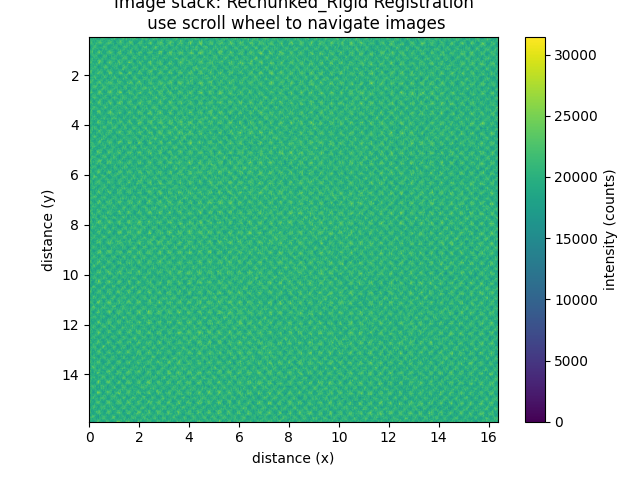

In [40]:
from pyTEMlib import image_tools
rigid_registered_dataset = image_tools.rigid_registration(dataset)
v = rigid_registered_dataset.plot()

### Determine Quality of Rigid Registration

First we fit a polynom of degree **polynom_degree** onto the drift of x and y separately.

The Nion STEMs are extremly stable and sub_pixel drift per image can be achieved.

A pixel of size 30pm distributed over 512 pixel (the size of many images) is obviously negletible.

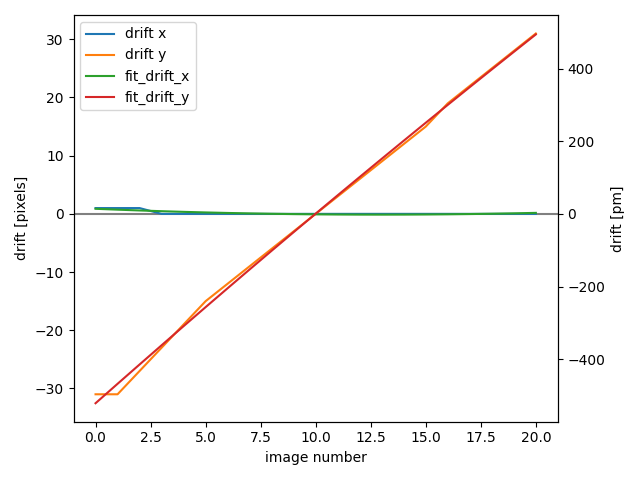

In [43]:
scale_x = file_tools.get_slope(rigid_registered_dataset.x.values)*1000.
drift = rigid_registered_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.05


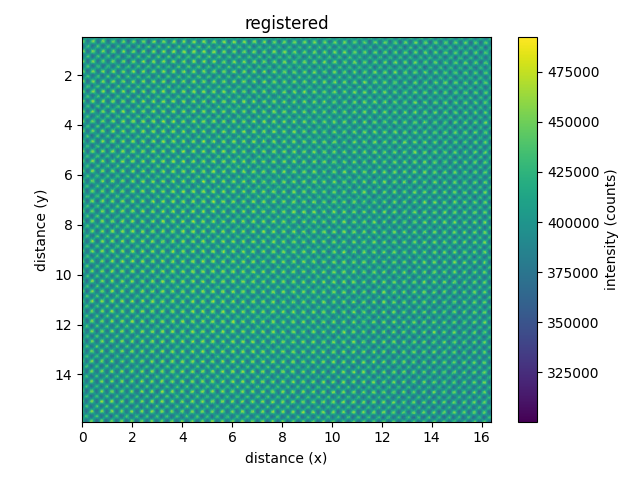

In [46]:
image = rigid_registered_dataset.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'

image.set_dimension(0,rigid_registered_dataset.dim_1)
image.set_dimension(1,rigid_registered_dataset.dim_2)
print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view =image.plot()


In [59]:
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = dataset[0]

offset_image = datset[1]


# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
shift_cc = np.argmax(cc_image)-512
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift} by phase_cross_correlation')
print(f'Detected pixel offset (y, x): {shift_cc} by  normal cross_correlation')


# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift_cc*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

NameError: name 'datset' is not defined

### Log Rigid Registration

We store the croped image-stack and drift-data here.

In [47]:
datasets['Log_000'] = image.copy()


## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

  0%|          | 0/20 [00:00<?, ?it/s]

:-)
You have successfully completed Diffeomorphic Demons Registration


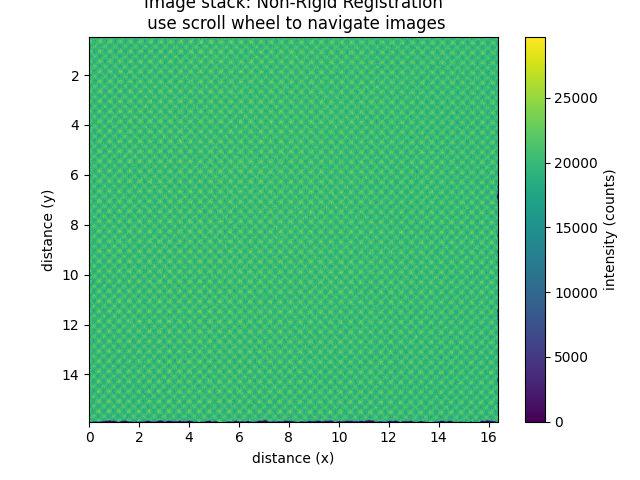

In [58]:
non_rigid_registered = it.demon_registration(rigid_registered_dataset)

view = non_rigid_registered.plot()

### Contrast
The image should have improved in contrast and signal noise ratio.

In [57]:
image = non_rigid_registered.sum(axis=0)
image = image[:-4,:]
image.data_type = 'image'
image.title = 'registered'
image.set_dimension(0,non_rigid_registered.dim_1)
image.set_dimension(1,non_rigid_registered.dim_2)

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view = image.plot()

AttributeError: 'Array' object has no attribute 'set_dimension'

### Log Non-Rigid Registration

In [21]:
datasets['Log_001'] = non_rigid_registered

A tree-like plot of the file

## Comparison of Different Dataset

A convenient function to select a dataset (for further processing, visualization or whatever)

In [11]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (a)', 'Log_000: register…

The selected dataset can then easily be plotted

<IPython.core.display.Javascript object>


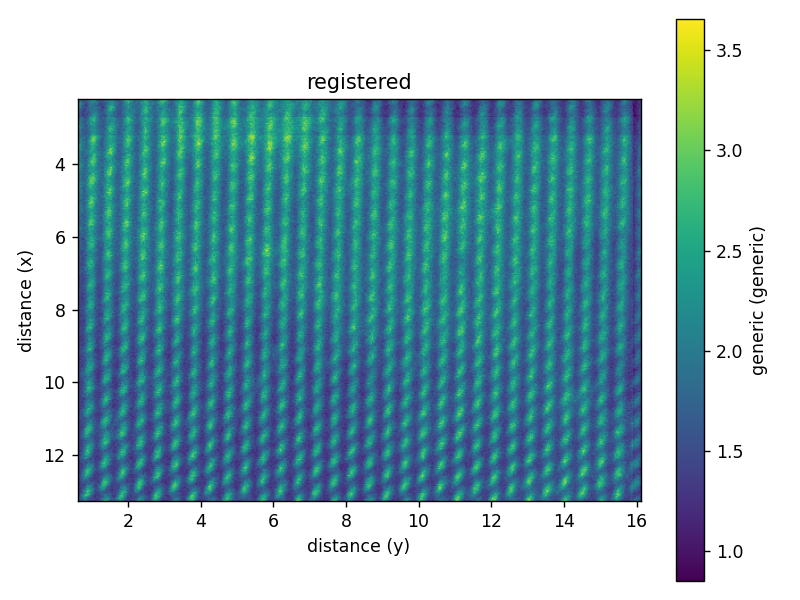

In [12]:
view = chooser.dataset.plot()

## Save File
let's save the datasets

In [13]:
h5_group = ft.save_dataset(datasets, filename=dataset.metadata['filename'])

C:\Users\gduscher\.conda\envs\ase\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\.conda\envs\ase\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


In [14]:
print('original file ', dataset.metadata['filename'])
print('was sved to: '+ h5_group.file.filename)

original file  C:/Users/gduscher/Documents/2022-Experiment/Nion Swift Project 09022022 Data/20220909-115644/data_1VSZR6JNVVO6LTJ5AOSLY1ECB.h5
was sved to: C:/Users/gduscher/Documents/2022-Experiment/Nion Swift Project 09022022 Data/20220909-115644\data_1VSZR6JNVVO6LTJ5AOSLY1ECB.hf5


Please note, that the file is still open, so we need to close it.

In [15]:
h5_group.file.close()

### Adaptive Fourier Filter 

In [ ]:
chooser = ft.ChooseDataset(datasets)

Contrast = 0.14


<IPython.core.display.Javascript object>


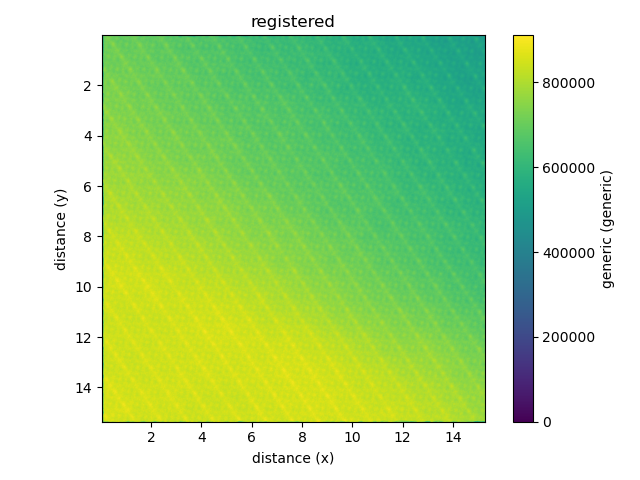

In [3]:
dataset = chooser.dataset
image = dataset.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view = image.plot()


fft :
	smoothing : 1
	minimum_intensity : 14.971004411718841
	maximum_intensity : 21.955855849170504
source:  registered


<IPython.core.display.Javascript object>


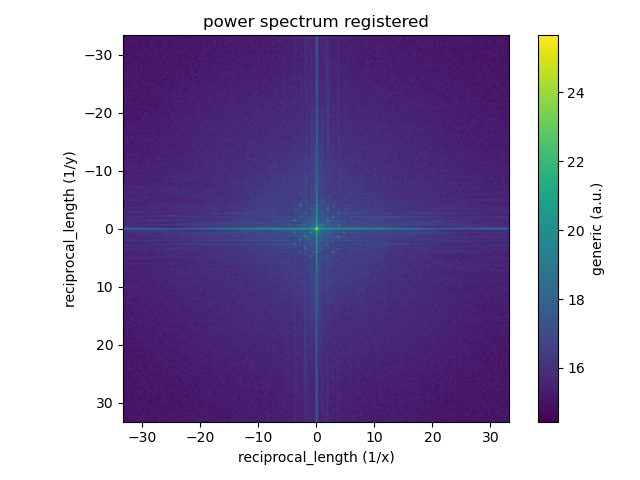

In [4]:
power_spectrum = it.power_spectrum(image, smoothing=1)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = power_spectrum.plot()

In [ ]:
# ------Input----------
spot_threshold=0.03
# ---------------------

spots = it.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<8,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
spots = spots[np.abs(spots[:,0])> .0001]
spots = spots[np.abs(spots[:,1])> .0001]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4)

<IPython.core.display.Javascript object>


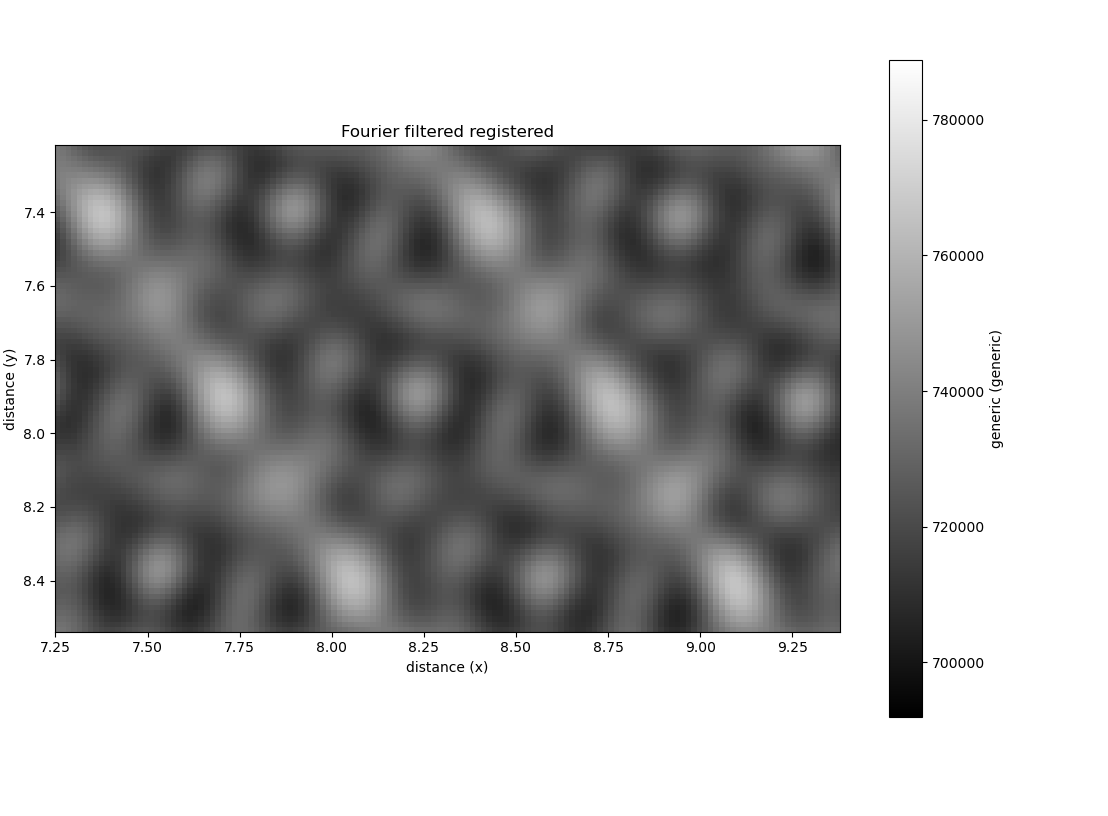

In [10]:
filtered_dataset = it.adaptive_fourier_filter(image, spots, low_pass=.03, reflection_radius=.3)
view = filtered_dataset.plot(cmap='gray')